# KarriereAI
#### A deep learning model used to predict viable career paths to a user based on their skills and interests.

#### Purpose
KarriereAI will classify the appropriate career within technology for a user from an interactive quiz input. The quiz is used to determine a user's skills and interests, before the model will predict a fitting career based on the input data.

#### Dataset
The dataset to be used is from the paper Skill2vec: A Machine Learning Approach for Determining the Relevant Skills from Job Description, by Van-Duyet Le et al. <a href="https://arxiv.org/pdf/1707.09751">here</a>. Containing relevant columns of job titles related to a free-text field of job descriptions describing relevant skills. 

Part of engineering the  model requires preprocessing of the dataset in to prepare it for training, analyzed through an exploratory data analysis (EDA).

#### Model Architecture
The model's architecture s a feed-forward neural network (FNN) for classification, using a multi-layer-perceptron (MLP) architecture suitable for structured data classification. 

#### Evaluation
As far as evaluation goes, a confusion matrix and an F1 score will be computed along with standard evaluation metrics like accuracy, recall and precision.

### Step 1 - Importing Libraries and Loading the Data 
We will be needing different libraries from <a href="https://keras.io/api/">Keras</a> and <a href="https://www.tensorflow.org/api_docs/python/tf">TensorFlow</a> among others to make computations on the dataset.

In [1]:
# Model processing
import pandas
import tensorflow
import keras
import numpy

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from keras import layers, Sequential, Input

# Other
import datetime

# For plotting
%matplotlib inline
import matplotlib.pyplot as pyplot

import seaborn
seaborn.set_theme (style = "whitegrid")

# %load_ext tensorboard

After importing relevant libraries, we load the dataset we wish to train the model on.

In [2]:
# Load dataset
data = pandas.read_csv ("data/mustHaveSkills.csv", header = 0, encoding ='ISO-8859-1')

# (Van-Duyet, et al., 2017)

### Step 2 - Taking a Look at the Data

To create optimal and smooth-running Python for the model we want to  study the shape of the data.

In [3]:
# Basic information about dataset
print ("Shape of dataset:", data.shape, "\n")
print ("Information about dataset:")
data.info()

Shape of dataset: (261724, 3) 

Information about dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261724 entries, 0 to 261723
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   job_brief_id  261724 non-null  int64 
 1   keyword_name  261717 non-null  object
 2   job_title     261724 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.0+ MB


#### 1.1 String Cleanup

In [4]:
# String magic
data ['keyword_name'] = data ['keyword_name'].str.lower()
data ['job_title'] = data ['job_title'].str.lower()

# Drop duplicates
data = data [data ["job_title"] != 0]
print (data.info())

# (Van-Duyet, et al., 2017)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261724 entries, 0 to 261723
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   job_brief_id  261724 non-null  int64 
 1   keyword_name  261717 non-null  object
 2   job_title     261724 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.0+ MB
None


### Step 3 - Exploratory Data Analysis (EDA)

To know what data the model will injest, taking a closer look by constructing plots and 

#### 3.1 Plotting Jobs and Skills
##### 3.1.1 Jobs

In [5]:
# Function to count number of occurrences 
def count_items(series):
    items = series.dropna().apply(lambda x: x.split(";"))
    flat_list = [item.strip() for sublist in items for item in sublist]
    return pandas.Series(flat_list).value_counts()

# (Shamim, 2023)

In [6]:
# Count Jobs
job_count = count_items(data["job_title"])
print("Most Common Jobs:\n", job_count)

Most Common Jobs:
 software engineer                         8765
software developer                        5098
engineer                                  3616
manager                                   2824
developer                                 2454
                                          ... 
statistical programer                        1
commercial finance manager                   1
campus manager                               1
level manger or director or consultant       1
quality assurance or quality                 1
Name: count, Length: 4597, dtype: int64


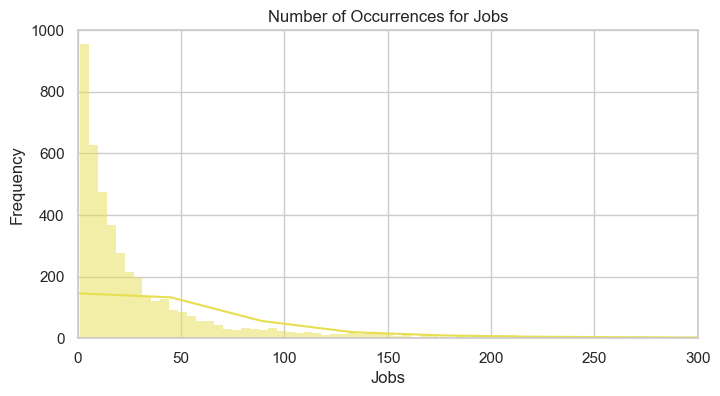

In [7]:
# Plot count for jobs
pyplot.figure (figsize = (8, 4))
seaborn.histplot (job_count, kde = True, color = "#e7de50")
pyplot.title ("Number of Occurrences for Jobs")
pyplot.xlabel ("Jobs")
pyplot.ylabel ("Frequency")
pyplot.xlim((0, 300))
pyplot.ylim((0, 1000))
pyplot.show ()

In [8]:
# Display jobs count
job_count

software engineer                         8765
software developer                        5098
engineer                                  3616
manager                                   2824
developer                                 2454
                                          ... 
statistical programer                        1
commercial finance manager                   1
campus manager                               1
level manger or director or consultant       1
quality assurance or quality                 1
Name: count, Length: 4597, dtype: int64

##### 3.1.2 Skills

In [9]:
# Count Skills
skills_count = count_items(data["keyword_name"])
print("Most Common Skills:\n", skills_count)

Most Common Skills:
 java                                                          4588
c++                                                           3193
j2ee                                                          2255
python                                                        2177
javascript                                                    2004
                                                              ... 
phr/sphr                                                         1
business partners                                                1
operations manager                                               1
t24                                                              1
(quality or qe) and (electrical or mechanical or software)       1
Name: count, Length: 6876, dtype: int64


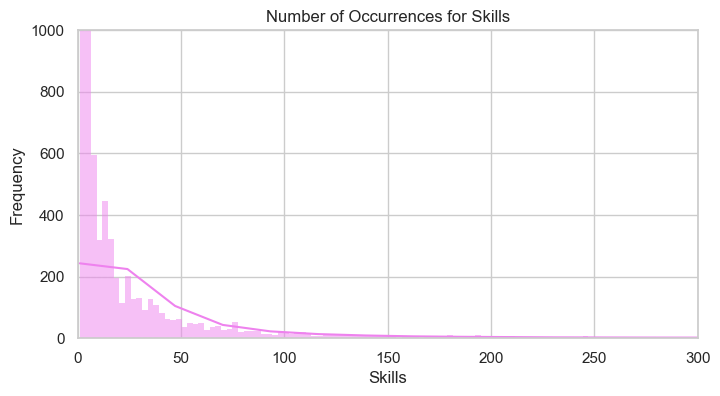

In [10]:
# Plot count for skills
pyplot.figure (figsize = (8, 4))
seaborn.histplot (skills_count, kde = True, color = "violet")
pyplot.title ("Number of Occurrences for Skills")
pyplot.xlabel ("Skills")
pyplot.ylabel ("Frequency")
pyplot.xlim((0, 300))
pyplot.ylim((0, 1000))
pyplot.show ()

In [11]:
# Display skills count
skills_count

java                                                          4588
c++                                                           3193
j2ee                                                          2255
python                                                        2177
javascript                                                    2004
                                                              ... 
phr/sphr                                                         1
business partners                                                1
operations manager                                               1
t24                                                              1
(quality or qe) and (electrical or mechanical or software)       1
Name: count, Length: 6876, dtype: int64

### Step 4: Preprocessing of Data

For the purpose of cleaning the dataset to make sure the model doesn't learn errors which will make predictions skewed.

#### 4.1 Titles dictionary
Grouping certain recurring job titles with each other.

In [12]:
# Building a dictonary for certain similar job titles to be grouped together
remap_titles_dictionary = {
    # FULLSTACK
    "software engineer": "software developer",  
    "engineer": "software developer",
    "developer": "software developer",
    "software development engineer": "software developer",
    "senior software engineer": "software developer",
    "sr. software engineer": "software developer",
    "sde": "software developer",
    "programmer": "software developer",
    "software development": "software developer",
    "senior engineer": "software developer",
    "software programmer" : "software developer",
    "senior developer" : "software developer",
    "software" : "software developer",
    "software engineering" : "software developer",
    "swe" : "software developer",
    "fullstack engineer" : "software developer",
    
    # JAVA
    "java developer": "software developer",     
    "java engineer": "software developer",
    "jee developer": "software developer",
    "jee engineer": "software developer",   
    "j2ee developer": "software developer",
    "j2ee engineer": "software developer",
    
    # TESTING
    "sdet": "test engineer",
    "validation": "test engineer",
    "validation engineer": "test engineer",
    
    # LEAD DEVELOPER
    "lead developer": "lead developer",
    "lead engineer": "lead developer",
    "lead java developer": "lead developer",
    "software development lead": "lead developer",
    "lead software engineer": "lead developer",
    "principal software engineer": "lead developer",
    
    # PROJECT MANAGER
    "engineering manager": "project manager",
    "product manager": "project manager",
    "director": "project manager",
    "manager": "project manager",
    "program manager": "project manager",
    "software manager": "project manager",
    "software development manager": "project manager",
    "technical program manager": "project manager",
    "software engineering manager": "project manager",
    "staff engineer": "project manager",
    "engineer manager": "project manager",
    
    # CONSULTANT
    "consulting": "consultant",
    
    # CONTRACTOR
    "contractor": "contractor",
    "contracting": "contractor",
    "freelancing": "contractor",
    "freelance": "contractor",
    "independent": "contractor",
    "specialist": "contractor",
    "seeking": "contractor",
    "looking": "contractor",
    "interim": "contractor",
    
    # QUALITY ASSURANCE
    "qa": "quality assurance",
    "quality": "quality assurance",
    "qc": "quality assurance",
    "quality engineer": "quality assurance",
    "quality control": "quality assurance",
    "qa engineer": "quality assurance",
    "qa manager": "quality assurance",
    "quality systems": "quality assurance",
    "quality assurance engineer": "quality assurance",
    "quality manager": "quality assurance",
    "quality operations": "quality assurance",
    
    # ACCOUNTING
    "account manager": "accounting",
    "account": "accounting",
    "accounts": "accounting",
    "accounting manager": "accounting",
    "ae": "accounting",
    "finance": "accounting",
    "account executive": "accounting",
    
    # SALES
    "sales manager": "sales",
    "sales": "sales",
    "sales planner": "sales",
    "sales director": "sales",
    "sale": "sales",
    "sales executive": "sales",
    "sales engineer": "sales",
    
    # BUSINESS
    "business development manager": "business", 
    "bdm": "business",
    "title cao": "business",
    "business development": "business",
    "bd manager": "business",
    "business analyst": "business",
    
    # MARKETING
    "marketing manager": "marketing",
    "campaign manager": "marketing",
    
    # SITE RELIABILITY ENGINEER
    "sre": "site reliability engineer",
    
    # LEADER
    "owner": "manager",
    "vp": "manager",
    "head": "manager",
    "lead": "manager",
    "senior manager": "manager",
    
    # STATISTICAL PROGRAMMER
    "statistician": "statistical programmer",
    
    # DATA SCIENTIST
    "scientist": "data scientist",
    "data science": "data scientist",
    "research associate": "data scientist",
    
    # FRONT END DEVELOPER
    "front end engineer": "frontend developer",
    "front-end developer": "frontend developer",
    "frontend engineer": "frontend developer",
    "front end developer": "frontend developer",
    "javascript engineer": "frontend developer",
    "javascript developer": "frontend developer",
    "web developer": "frontend developer",
    
    # BACKEND DEVELOPER
    "backend engineer": "backend developer",
    
    # DEVOPS
    "devops": "devops engineer",
    "dev ops": "devops engineer",
    
    # REGULATORY AFFAIRS
    "regulatory affairs specialist": "regulatory affairs",
    "regulatory affairs associate": "regulatory affairs",
    "ra": "regulatory affairs",
    
    # SYSTEMS ENGINEER
    "data engineer": "system engineer",
    "systems engineer": "system engineer",
    "architect": "system engineer",
    "software architect": "system engineer",
        
    # CLINICAL TRIAL MANAGER
    "ctm": "clinical trial manager",
    "clinical research": "clinical trial manager",
    "clinical study manager": "clinical trial manager",
    "cra": "clinical trial manager",
    "clinical trials manager": "clinical trial manager",
    "clinical research associate": "clinical trial manager",
    "clinical operations manager": "clinical trial manager",
    "bioprocess scientist": "clinical trial manager",
    "drug safety": "clinical trial manager",
    "researcher": "clinical trial manager",
    "site manager": "clinical trial manager",
    
    # MOBILE DEVELOPER
    "ios engineer": "mobile developer",
    "application engineer": "mobile developer",
    "android engineer": "mobile developer",
    
    # MEDIA PLANNER
    "assistant media planner": "media planner",
    
    # DESIGNER
    "ux designer": "designer",
    "ui designer": "designer",
    "ux engineer": "designer",
    "ui/ux engineer": "designer",
    "ui engineer": "designer",
    
    # FIELD APPLICATIONS ENGINEER
    "fae": "field applications engineer",

    # GAME DEVELOPER
    "game programmer": "game developer",
    "level designer": "game developer",
    "mission designer": "game developer",
}


In [13]:
# Building a dictonary for certain similar skills to be grouped together
remap_skills_dictionary = {
    # JAVA
    "j2ee": "java",
    "j2ee": "java",
    "j2me": "java",
    "javase": "java",
    "javame": "java",
    "j2seb": "java",
    "javaee": "java",
    "j2se": "java",
    "javaseb": "java",
    
    # HTML
    "html5": "html",
    
    # REGULATORY AFFAIRS
    "regulatory": "regulatory affairs",
    "ra": "regulatory affairs",
    
    # JAVASCRIPT
    "java-script": "javascript",
    "java script": "javascript",
    
    # QUALITY ASSURANCE
    "qa": "quality assurance",
    
    # QUALITY CONTROL
    "qc": "quality control",
    
    # GAMES
    "game": "games",
}

In [ ]:
# Function to use titles dictionary on dataset
def remap_titles (value) : 
    return remap_titles_dictionary.get (value, value)

# # Function to use skills dictionary on dataset
# def remap_skills (value) : 
#     return remap_skills_dictionary.get (value, value)

# Making sure id column remains unchanged
def no_change (value) :
    return value

In [15]:
# Comparison of data before
data

,job_brief_id,keyword_name,job_title
0,4,php,web designer
1,4,php,web developer
2,4,php,full stack developer
3,4,php,dev ops
4,4,php,product manager
...,...,...,...
261719,12835,c++,game programmer
261720,12835,c#,software developer
261721,12835,c#,software engineer
261722,12835,c#,game developer


In [ ]:
# Remap titles
data = data.apply({
    "job_brief_id": no_change,
    "keyword_name": no_change,
    "job_title": remap_titles,
})

# Comparison of data after
data

,job_brief_id,keyword_name,job_title
0,4,php,web designer
1,4,php,frontend developer
2,4,php,full stack developer
3,4,php,devops engineer
4,4,php,project manager
...,...,...,...
261719,12835,c++,game developer
261720,12835,c#,software developer
261721,12835,c#,software developer
261722,12835,c#,game developer


#### 4.3 Plotting Skills and Titles After Remapping

In [17]:
# Count Jobs
job_count = count_items(data["job_title"])
print("Most Common Jobs:\n", job_count)

Most Common Jobs:
 software developer                     38977
project manager                        13544
quality assurance                       8432
contractor                              7327
clinical trial manager                  5892
                                       ...  
strategic manager                          1
security assurance coordinator             1
technical recuiter                         1
marketing games manager                    1
third party marketing games manager        1
Name: count, Length: 4465, dtype: int64


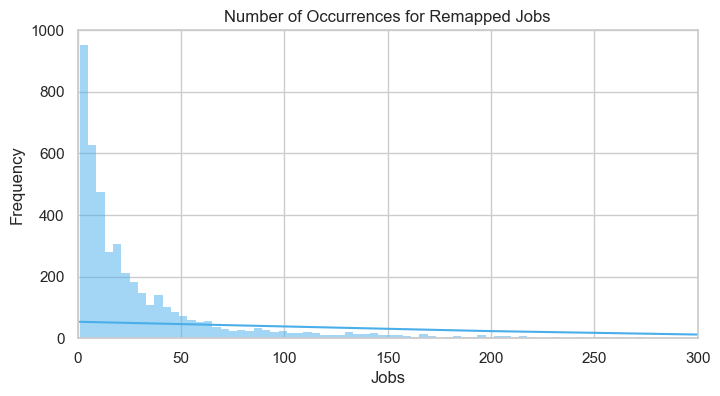

In [18]:
# Plot count for jobs
pyplot.figure (figsize = (8, 4))
seaborn.histplot (job_count, kde = True, color = "#49aeea")
pyplot.title ("Number of Occurrences for Remapped Jobs")
pyplot.xlabel ("Jobs")
pyplot.ylabel ("Frequency")
pyplot.xlim((0, 300))
pyplot.ylim((0, 1000))
pyplot.show ()

In [19]:
# Display jobs count
job_count

software developer                     38977
project manager                        13544
quality assurance                       8432
contractor                              7327
clinical trial manager                  5892
                                       ...  
strategic manager                          1
security assurance coordinator             1
technical recuiter                         1
marketing games manager                    1
third party marketing games manager        1
Name: count, Length: 4465, dtype: int64

In [ ]:
# # Count Skills
# skills_count = count_items(data["keyword_name"])
# print("Most Common Skills:\n", skills_count)

Most Common Skills:
 java                                                       13462
c++                                                         3193
javascript                                                  2935
python                                                      2177
regulatory affairs                                          2122
                                                           ...  
investigations or deviations or complaints                     1
material creation skills for creating either characters        1
environments                                                   1
z                                                              1
current-gen game content development                           1
Name: count, Length: 6860, dtype: int64


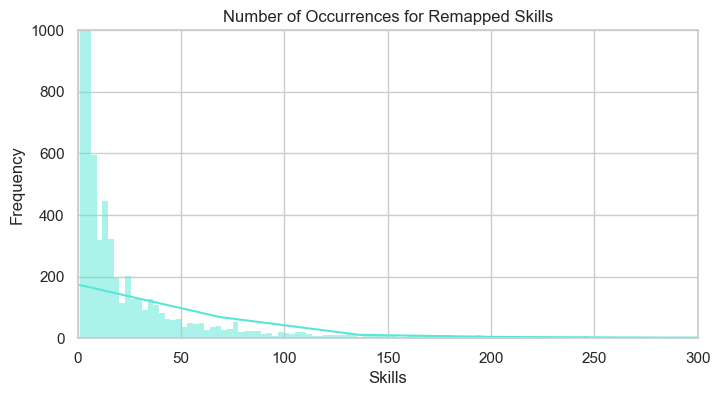

In [ ]:
# # Plot count for skills
# pyplot.figure (figsize = (8, 4))
# seaborn.histplot (skills_count, kde = True, color = "#58e7d7")
# pyplot.title ("Number of Occurrences for Remapped Skills")
# pyplot.xlabel ("Skills")
# pyplot.ylabel ("Frequency")
# pyplot.xlim((0, 300))
# pyplot.ylim((0, 1000))
# pyplot.show ()

In [ ]:
# # Display skills count
# skills_count

java                                                       13462
c++                                                         3193
javascript                                                  2935
python                                                      2177
regulatory affairs                                          2122
                                                           ...  
investigations or deviations or complaints                     1
material creation skills for creating either characters        1
environments                                                   1
z                                                              1
current-gen game content development                           1
Name: count, Length: 6860, dtype: int64

#### 4.2 Normalization
Normalizing the job titles with less occurrences than an input threshold.

In [ ]:
# Remove jobs below threshold of top 100
job_count = job_count.iloc[0:100]
print ("Job Count")
print (job_count)

Job Count
software developer             38977
project manager                13544
quality assurance               8432
contractor                      7327
clinical trial manager          5892
                               ...  
finance accounting manager       200
computer system validation       199
safety operations scientist      198
vice president                   197
product management               197
Name: count, Length: 100, dtype: int64


In [24]:
# Remove skills for jobs below threshold of top 100
skills_count = skills_count.iloc[0:100]
print ("Skill Count")
print (skills_count)

Skill Count
java                  13462
c++                    3193
javascript             2935
python                 2177
regulatory affairs     2122
                      ...  
hr                      327
sterile                 326
front end               324
investigation           324
deviations              323
Name: count, Length: 100, dtype: int64


In [25]:
# Trimming the data to only keep the most common job titles
data = data [data ['job_title'].isin (job_count.keys())]
data

,job_brief_id,keyword_name,job_title
1,4,php,frontend developer
3,4,php,devops engineer
4,4,php,project manager
8,4,html,frontend developer
10,4,html,devops engineer
...,...,...,...
261719,12835,c++,game developer
261720,12835,c#,software developer
261721,12835,c#,software developer
261722,12835,c#,game developer


In [26]:
# Trimming the data to only keep the most common skills
data = data [data ['keyword_name'].isin (skills_count.keys())]
data

,job_brief_id,keyword_name,job_title
8,4,html,frontend developer
10,4,html,devops engineer
11,4,html,project manager
15,4,css,frontend developer
17,4,css,devops engineer
...,...,...,...
261719,12835,c++,game developer
261720,12835,c#,software developer
261721,12835,c#,software developer
261722,12835,c#,game developer


In [27]:
# Setup for Usable Data
dataset = data.groupby (['job_brief_id', 'job_title'])['keyword_name'].apply(list)
print (dataset.head())

job_brief_id  job_title         
4             devops engineer                                      [html, css, mysql]
              frontend developer                                   [html, css, mysql]
              project manager                                      [html, css, mysql]
6             consultant            [java, java, jee, java, java, java, java, java...
              software developer    [java, java, java, java, jee, jee, java, java,...
Name: keyword_name, dtype: object


In [28]:
# Drop the id column which is unnecessary for training
dataframe = dataset.droplevel(0)

# Turn this into the correct type
dataframe = dataframe.to_frame("skills")
dataframe = dataframe.reset_index()
dataframe

,job_title,skills
0,devops engineer,"[html, css, mysql]"
1,frontend developer,"[html, css, mysql]"
2,project manager,"[html, css, mysql]"
3,consultant,"[java, java, jee, java, java, java, java, java..."
4,software developer,"[java, java, java, java, jee, jee, java, java,..."
...,...,...
8708,software developer,[design]
8709,quality assurance,"[test, test, python, python, c++, c++]"
8710,accounting,"[sales, german]"
8711,game developer,"[c, c, c++, c++, c#, c#]"


#### 4.3 Encoding Input

Encoding the input for the model, turning text values into numerical values for processing.

In [29]:
# Store jobs and skills in lists
skills_list = skills_count.keys ().to_list ()
titles_list = job_count.keys ().to_list ()

# Save skills and job titles to files for decoding output from model
with open (r'model/skills.txt', 'w') as fp:
    for skill in skills_list:
        # write each item on a new line
        fp.write("%s\n" % skill)
    print('Saved skills to file')

with open (r'model/titles.txt', 'w') as fp:
    for title in titles_list:
        # write each item on a new line
        fp.write("%s\n" % title)
    print('Saved job titles to file')

Saved skills to file
Saved job titles to file


In [30]:
# Map skills to an index
def map_skills_to_index (skills):
    return list (map (lambda skill: skills_list.index(skill), skills))

# Map job titles to an index
def map_title_to_index (title):
    return titles_list.index(title)

In [31]:
# Method to update the string values to indices, matching the skills and titles
def update_values(row):
    if isinstance(row, str):
        return map_title_to_index(row)
    else:
        return map_skills_to_index(row)

dataframe = dataframe.map(update_values) 

dataframe

,job_title,skills
0,15,"[9, 18, 61]"
1,8,"[9, 18, 61]"
2,1,"[9, 18, 61]"
3,9,"[0, 0, 6, 0, 0, 0, 0, 0, 1, 12]"
4,0,"[0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
8708,0,[34]
8709,2,"[77, 77, 3, 3, 1, 1]"
8710,12,"[20, 90]"
8711,26,"[12, 12, 1, 1, 10, 10]"


In [32]:
# Defining the encoder for the skills
encoder = keras.layers.CategoryEncoding (
    num_tokens = skills_count.count(),
    output_mode = "multi_hot", 
)

In [33]:
# Running the encoder
feature_names = ["job_title", "skills"]

def encode_skills(row):
    return encoder(row).numpy()

feature_skills = list(map(encode_skills, dataframe["skills"].to_list()))
feature_skills

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 

### Step 5 - Building the Model

Building the FFN model, and training it.

#### 5.1 Training, Validation and Test Sets

In [34]:
# Defining the preprocessed skills and titles
feature_titles = dataframe["job_title"]

dataframe_skills = pandas.DataFrame(data = feature_skills)
dataframe_titles = pandas.DataFrame(data = feature_titles)

# Combining it all into a dataframe with columns for each skill
model_dataframe = dataframe_titles.merge(dataframe_skills, left_index=True, right_index=True)
model_dataframe

,job_title,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8708,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8709,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8710,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8711,26,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split (dataframe_skills, dataframe_titles, test_size = 0.3, random_state = 42)

#### 5.2 Training the Model

In [36]:
# Building the model
model = Sequential([
    Input (shape = (100, )),
    layers.Dropout (0.1),
    layers.Dense (400, activation = 'relu'),
    layers.Dropout (0.4),
    layers.Dense (400, activation = 'relu'),
    layers.Dropout (0.2), 
    layers.Dense (100, activation = 'softmax'),
])

# Compiling definitions
model.compile (
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = 'adam', 
    metrics = ['accuracy', 'precision', 'recall']
)

# Logging metrics for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard (log_dir = log_dir, histogram_freq = 1)

# Training the model
epochs = 32
history = model.fit (
    X_train, y_train,
    epochs = epochs, 
    batch_size = 1, 
    validation_split = 0.2,
    callbacks = [tensorboard_callback]
)

Epoch 1/32
4879/4879 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.2463 - loss: 3.2776 - precision: 0.7502 - recall: 9.3351e-04 - val_accuracy: 0.3434 - val_loss: 2.3585 - val_precision: 0.7903 - val_recall: 0.0014
Epoch 2/32
4879/4879 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.3328 - loss: 2.3092 - precision: 0.7600 - recall: 0.0022 - val_accuracy: 0.3377 - val_loss: 2.1338 - val_precision: 0.7512 - val_recall: 0.0016
Epoch 3/32
4879/4879 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.3544 - loss: 2.1428 - precision: 0.7333 - recall: 0.0026 - val_accuracy: 0.3369 - val_loss: 2.1075 - val_precision: 0.8201 - val_recall: 0.0019
Epoch 4/32
4879/4879 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.3590 - loss: 2.0394 - precision: 0.7886 - recall: 0.0030 - val_accuracy: 0.3762 - val_loss: 2.0458 - val_precision: 0.8089 - val_recall: 0.0025
Epoch 5/32
4879/4879 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.3727 - loss: 1.9968 - precision: 0.7591 - recall: 0.0033 - val_accuracy: 0.

Producing a summary of the model, we get a description of its architecture and parameter layout.

In [37]:
# A summary of the models architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 400)            │        40,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 400)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        40,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 722,702 (2.76 MB)

 Trainable params: 240,900 (941.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 481,802 (1.84 MB)

In [38]:
# Viewing the metrics prepared in TensorBoard
# %tensorboard --logdir logs/fit

#### 5.3 Saving the Model

In [39]:
# Saving the model to the model folder
model.save('model/karriereai_model_improved.keras')

### Step 6 - Evaluation
To illustrate the model's performance when predicting new outcomes, we use metrics like a confusion matrix fitting for classification, combined with standard metrics like accuracy.

#### 6.1 Confusion Matrix

In [40]:
# Prediction on the test set
y_prediction = model.predict (X_test)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


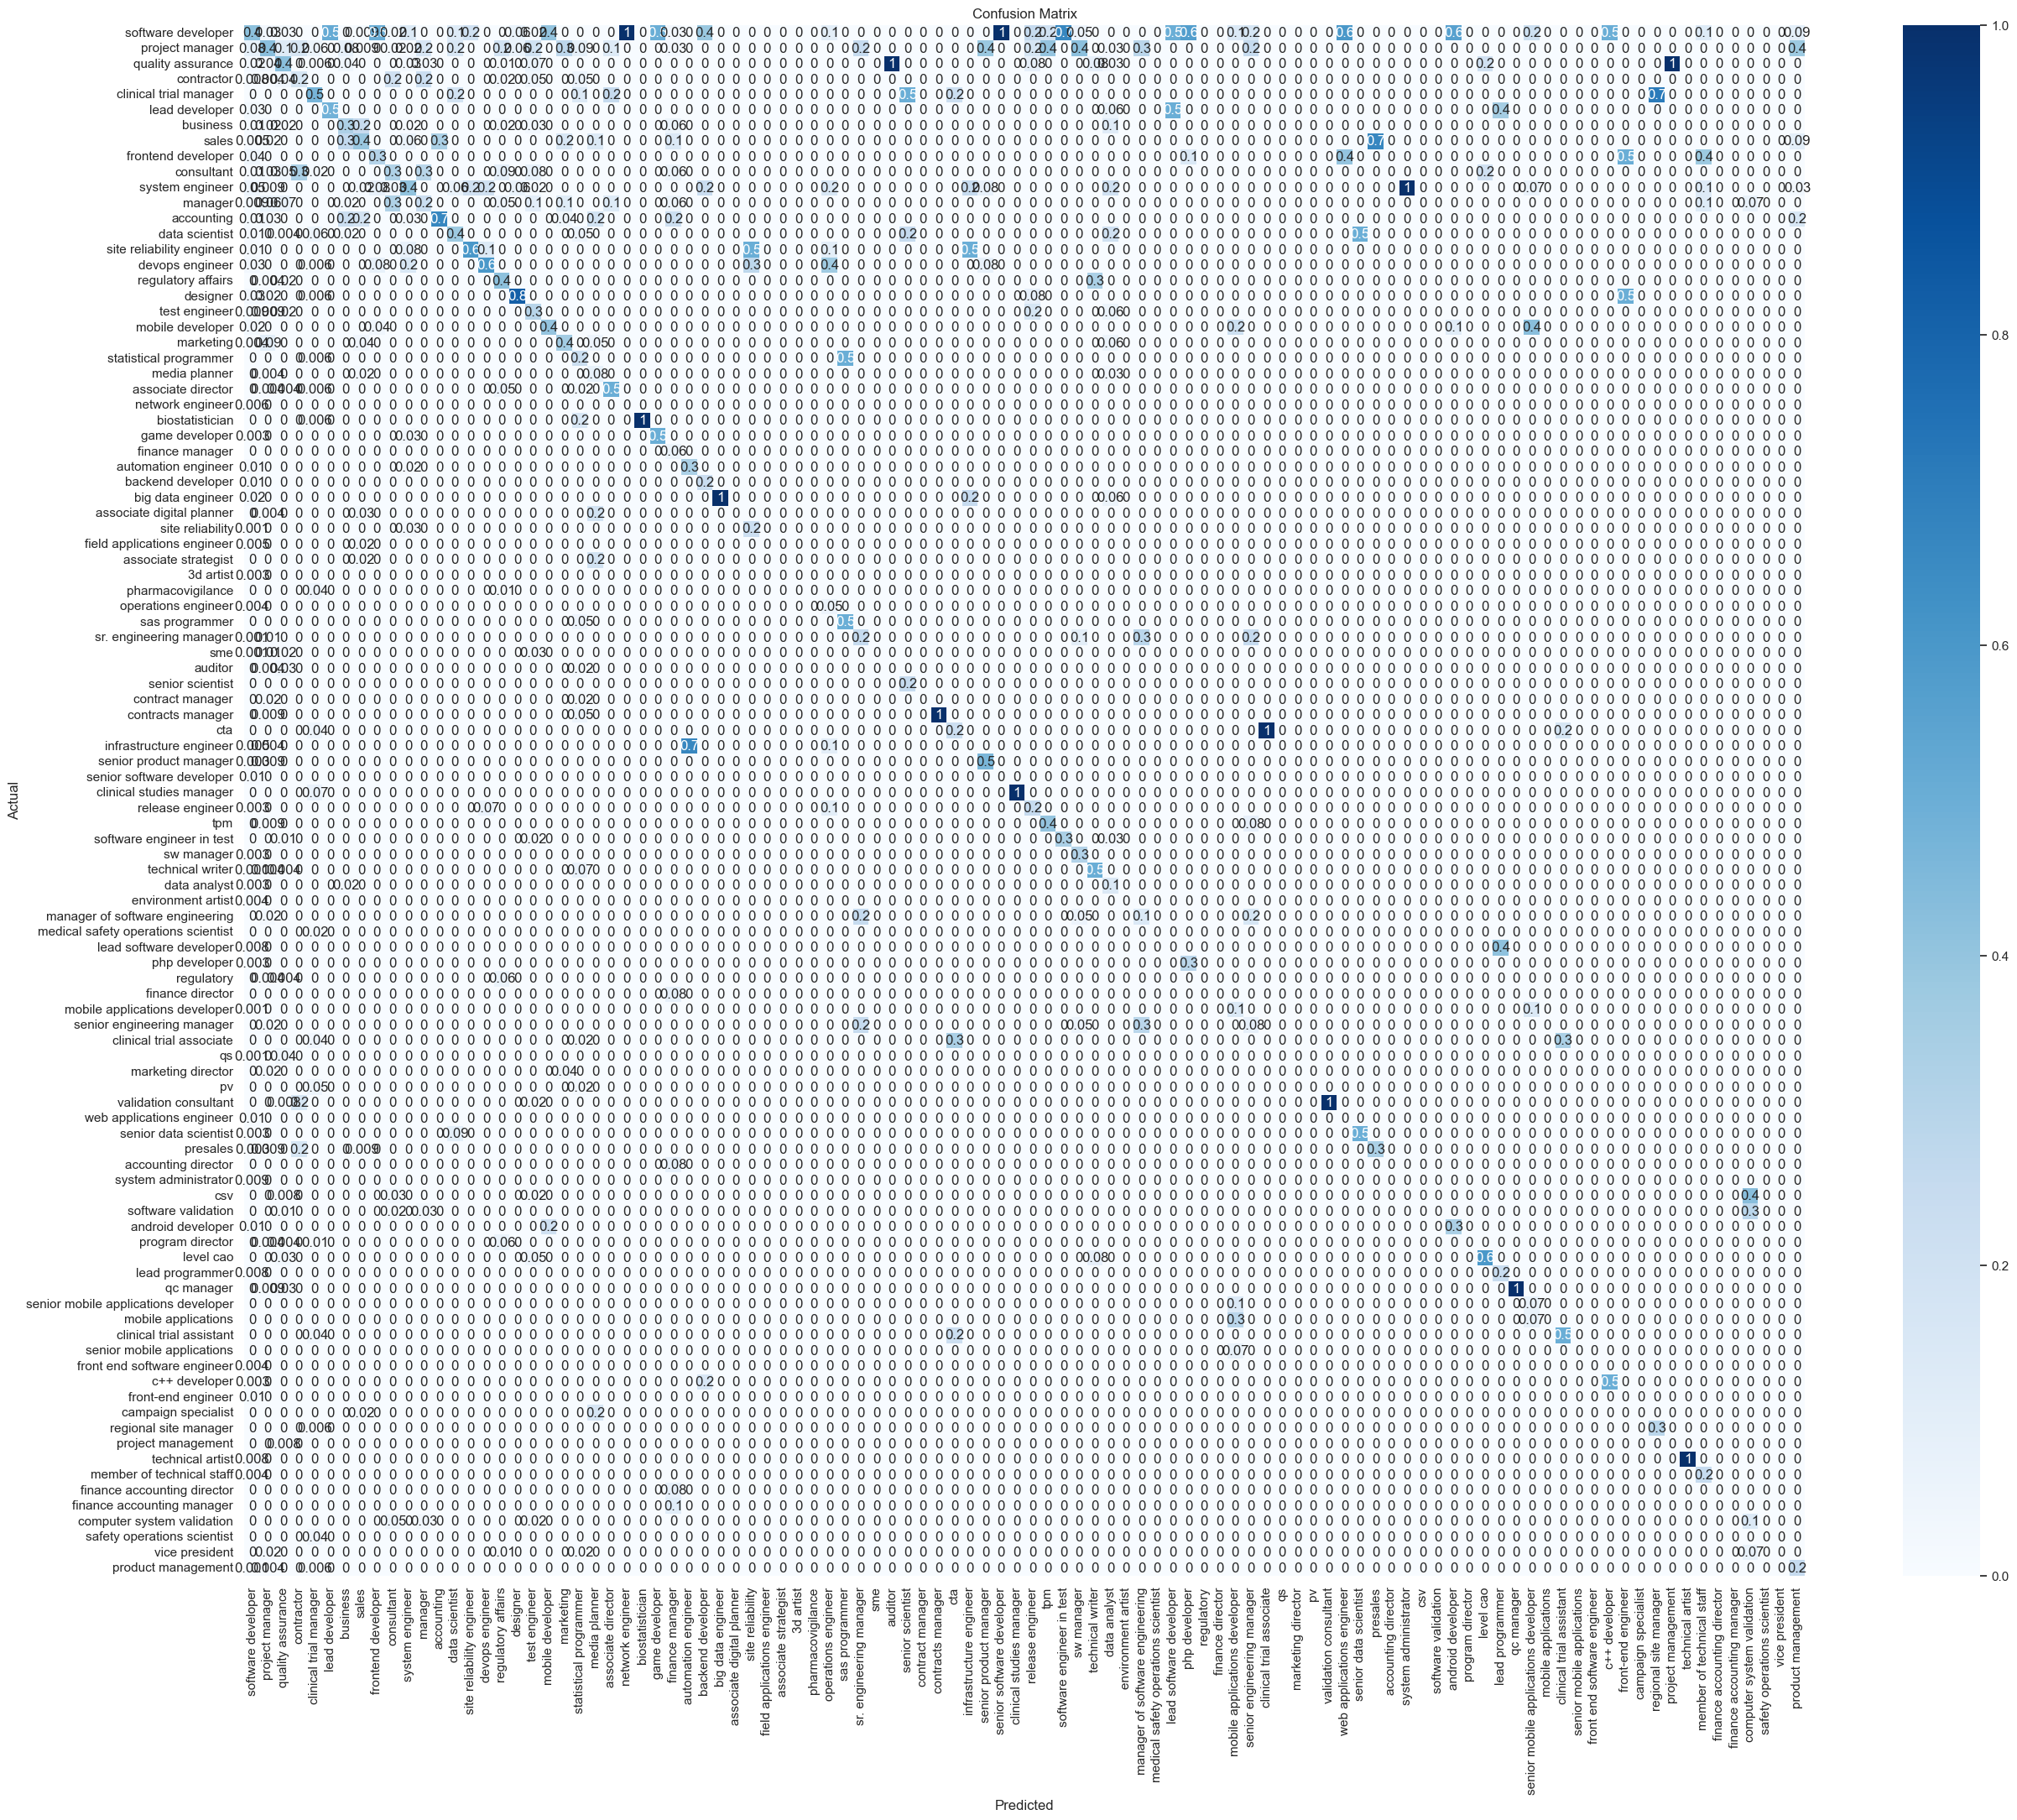

In [41]:
# Confusion matrix
conf_matrix = confusion_matrix (y_test, y_prediction.argmax(axis = 1), normalize='pred')
pyplot.figure (figsize = (30, 24))
seaborn.heatmap (conf_matrix, annot = True, fmt = ".1g", cmap = "Blues", 
            xticklabels = titles_list,
            yticklabels = titles_list)
pyplot.xlabel ("Predicted")
pyplot.ylabel ("Actual")
pyplot.title ("Confusion Matrix")
pyplot.show ()

# (Shamim, 2023)

#### 6.2 F1-Score

In [42]:
# Printing the F1-Score 
score =  f1_score (y_test, y_prediction.argmax(axis = 1), average = None)
print ("The highest F1-score:", numpy.max (score))
print ("The lowest F1-score:", numpy.min (score))

average_score = numpy.mean (score)
print ("The average F1-score:", numpy.round (average_score, 2))

The highest F1-score: 0.6666666666666666
The lowest F1-score: 0.0
The average F1-score: 0.19


#### 6.3 Precision, Accuracy, Recall

In [43]:
# Saving the epochs' range
epochs_range = range(epochs)

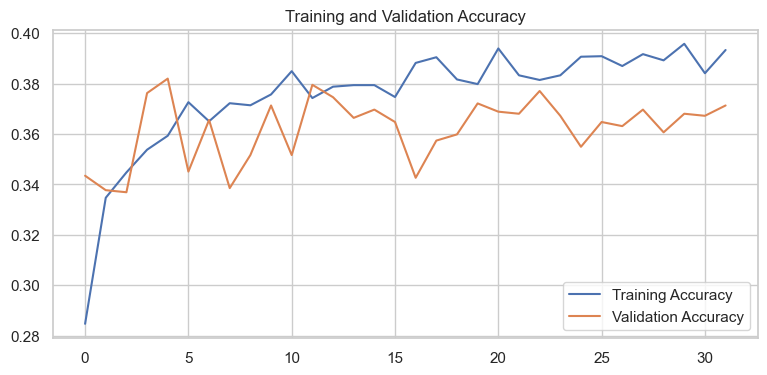

In [44]:
# Accuracy on training and validation data
accuracy = history.history ['accuracy']
validation_accuracy = history.history ['val_accuracy']

# Plotting accuracy
pyplot.figure (figsize = (20, 4))
pyplot.subplot (1, 2, 1)
pyplot.plot (epochs_range, accuracy, label = 'Training Accuracy')
pyplot.plot (epochs_range, validation_accuracy, label = 'Validation Accuracy')
pyplot.legend (loc = 'lower right')
pyplot.title ('Training and Validation Accuracy')

pyplot.show ()

# (Rege, et al., 2024)

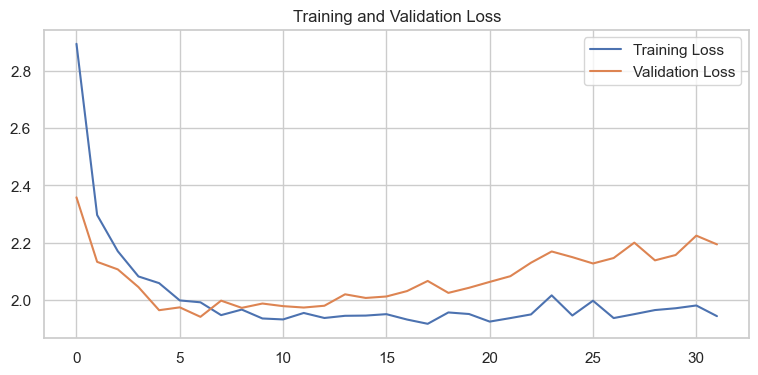

In [45]:
# Loss on training and validation data
loss = history.history ['loss']
validation_loss = history.history ['val_loss']

# Plotting loss
pyplot.figure (figsize = (20, 4))
pyplot.subplot (1, 2, 2)
pyplot.plot (epochs_range, loss, label = 'Training Loss')
pyplot.plot (epochs_range, validation_loss, label = 'Validation Loss')
pyplot.legend (loc = 'upper right')
pyplot.title ('Training and Validation Loss')

pyplot.show ()

# (Rege, et al., 2024)

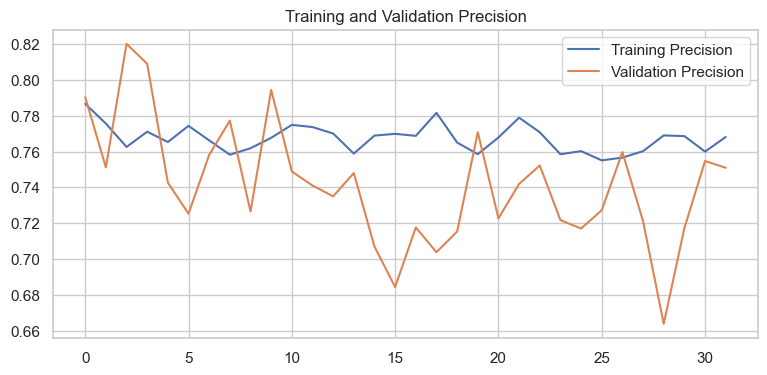

In [46]:
# Precision on training and validation data
precision = history.history ['precision']
validation_precision = history.history ['val_precision']

# Plotting loss
pyplot.figure (figsize = (20, 4))
pyplot.subplot (1, 2, 2)
pyplot.plot (epochs_range, precision, label = 'Training Precision')
pyplot.plot (epochs_range, validation_precision, label = 'Validation Precision')
pyplot.legend (loc = 'upper right')
pyplot.title ('Training and Validation Precision')

pyplot.show ()

# (Rege, et al., 2024)

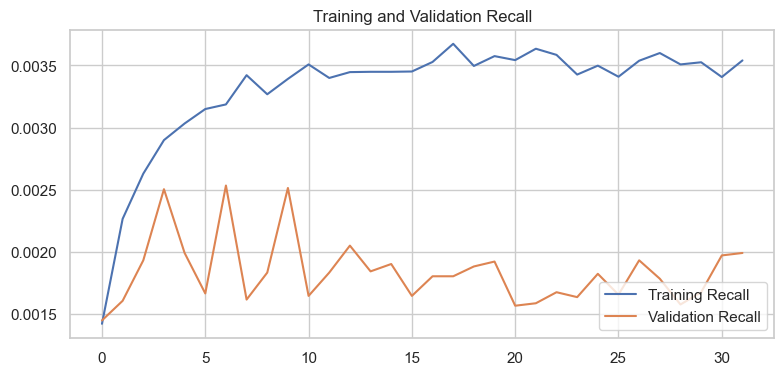

In [47]:
# Recall on training and validation data
recall = history.history ['recall']
validation_recall = history.history ['val_recall']

# Plotting recall
pyplot.figure (figsize = (20, 4))
pyplot.subplot (1, 2, 1)
pyplot.plot (epochs_range, recall, label = 'Training Recall')
pyplot.plot (epochs_range, validation_recall, label = 'Validation Recall')
pyplot.legend (loc = 'lower right')
pyplot.title ('Training and Validation Recall')

pyplot.show ()

# (Rege, et al., 2024)

### (Step 7 - Deployment For the Website)
To be able to have the model make predictions on new input through the career test, we have to prepare it for the TensorFlow JavaScript functionality.

#### 7.1 Converting to TensorFlow.js
*Warning: TensorFlowjs is not supported by Windows, and requires a UNIX-based operating system to work.* <br/><br/>
Uncomment the code below to convert the model to a TensorFlowjs supported version.

In [48]:
# import tensorflowjs

# # Converting the keras model to a tensorflow.js model
# tensorflowjs.converters.save_keras_model(model, 'model/tfjs')

Note:
The JSON file that is generated by this method is unfortunately incompatible with TensorFlowjs, and will need a slight adjustment to work in the bachelor project. Please perform the following change in the JSON model:<br/><br/>
Rename the variable
'batch_shape' to 'batch_input_shape'

#### References
Rege, A., Markhus, B. & Ceballos, A. (2024). *Fruitoo* [Code Repository]. https://www.kaggle.com/code/amalierege/fruit-bonanza#Fruitoo
<br/><br/>
Shamim, A. (2025, b). *AI_Career_Recommendation_EDA_ML* [Code Repository]. https://www.kaggle.com/code/adilshamim8/ai-career-recommendation-eda-ml 
<br/><br/>
Van-Duyet, L., Quan, V. M. & An, D. Q. (2017). *Skill2vec: Machine Learning Approach for Determining the Relevant Skills from Job Description* [Data set]. https://arxiv.org/pdf/1707.09751
